## Import Libraries

In [ ]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt

In [ ]:
# Softmax function
def softmax(xs):
  return np.exp(xs) / sum(np.exp(xs))

## A many-to-one Vanilla Recurrent Neural Network.

In [ ]:
class RNN:
  def __init__(self, input_size, output_size, modify_size = 1.0, hidden_size=64):
    # Weights
    self.Whh = randn(hidden_size, hidden_size) * modify_size
    self.Wxh = randn(hidden_size, input_size) * modify_size
    self.Why = randn(output_size, hidden_size) * modify_size

    # Biases
    self.bh = np.zeros((hidden_size, 1))
    self.by = np.zeros((output_size, 1))

  def forward(self, inputs):
    '''
    Perform a forward pass of the RNN using the given inputs.
    Returns the final output and hidden state.
    - inputs is an array of one hot vectors with shape (input_size, 1).
    '''
    h = np.zeros((self.Whh.shape[0], 1))

    self.last_inputs = inputs
    self.last_hs = { 0: h }

    # Perform each step of the RNN
    for i, x in enumerate(inputs):
      h = np.tanh(self.Wxh @ x + self.Whh @ h + self.bh)
      self.last_hs[i + 1] = h

    # Compute the output
    y = self.Why @ h + self.by

    return y, h

  def backprop(self, d_y, learn_rate=2e-2):
    '''
    Perform a backward pass of the RNN.
    - d_y (dL/dy) has shape (output_size, 1).
    - learn_rate is a float.
    '''
    n = len(self.last_inputs)

    # Calculate dL/dWhy and dL/dby.
    d_Why = d_y @ self.last_hs[n].T
    d_by = d_y

    # Initialize dL/dWhh, dL/dWxh, and dL/dbh to zero.
    d_Whh = np.zeros(self.Whh.shape)
    d_Wxh = np.zeros(self.Wxh.shape)
    d_bh = np.zeros(self.bh.shape)

    # Calculate dL/dh for the last h.
    # dL/dh = dL/dy * dy/dh
    d_h = self.Why.T @ d_y

    grads = [d_h.copy()]

    # Backpropagate through time.
    for t in reversed(range(n)):
      # An intermediate value: dL/dh * (1 - h^2)
      temp = ((1 - self.last_hs[t + 1] ** 2) * d_h)

      # dL/db = dL/dh * (1 - h^2)
      d_bh += temp

      # dL/dWhh = dL/dh * (1 - h^2) * h_{t-1}
      d_Whh += temp @ self.last_hs[t].T

      # dL/dWxh = dL/dh * (1 - h^2) * x
      d_Wxh += temp @ self.last_inputs[t].T

      # Next dL/dh = dL/dh * (1 - h^2) * Whh
      d_h = self.Whh @ temp

      grads.append(d_h.copy())

    return grads

    # Update weights and biases using gradient descent.
    self.Whh -= learn_rate * d_Whh
    self.Wxh -= learn_rate * d_Wxh
    self.Why -= learn_rate * d_Why
    self.bh -= learn_rate * d_bh
    self.by -= learn_rate * d_by

## Generate data

In [ ]:
'''
- Generate 1 sample to show gradients problem
- Input: 100 time-steps, each time-step input is a 100-dimensional vector
- Output: 2 classes
'''
X = np.random.randn(100, 100, 1)
y = np.random.randint(0, 2)

## Vanishing Problem

In [ ]:
# Initialize RNN model with small weights
rnn = RNN(100, 2, 1/100)

# Forward
out, _ = rnn.forward(X)
probs = softmax(out)

# Build dL/dy
d_L_d_y = probs
d_L_d_y[y] -= 1

# Backward
grads = rnn.backprop(d_L_d_y)

In [ ]:
norm = [np.linalg.norm(grad, 'fro') for grad in grads]
norm.reverse()

Text(0, 0.5, 'Gradient matrix norm')

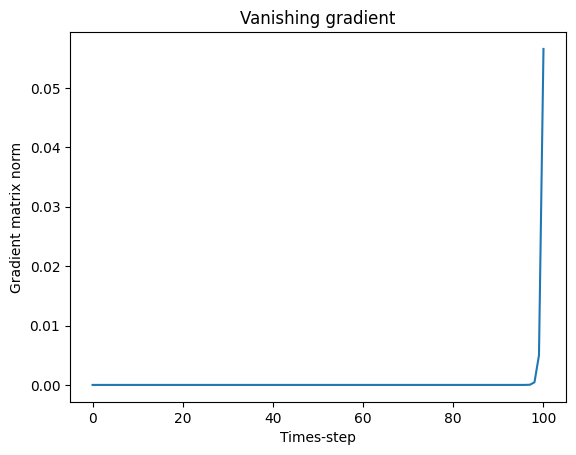

In [ ]:
plt.plot(range(len(norm)), norm)
plt.title('Vanishing gradient')
plt.xlabel('Times-step')
plt.ylabel('Gradient matrix norm')

## Exploding problem

In [ ]:
# Initialize RNN model with large weights
rnn = RNN(100, 2)

# Forward
out, _ = rnn.forward(X)
probs = softmax(out)

# Build dL/dy
d_L_d_y = probs
d_L_d_y[y] -= 1

# Backward
grads = rnn.backprop(d_L_d_y)

In [ ]:
norm = [np.linalg.norm(grad, 'fro') for grad in grads]
norm.reverse()

Text(0, 0.5, 'Gradient matrix norm')

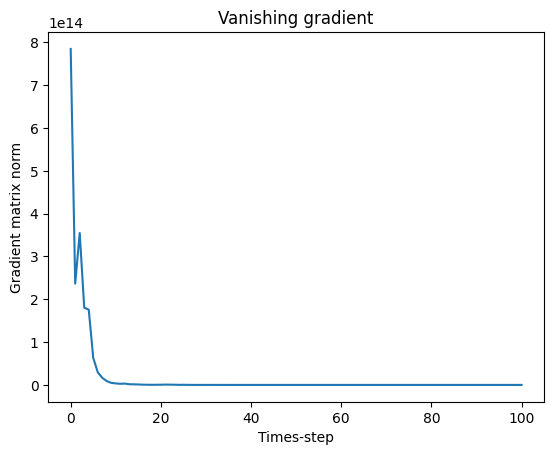

In [ ]:
plt.plot(range(len(norm)), norm)
plt.title('Vanishing gradient')
plt.xlabel('Times-step')
plt.ylabel('Gradient matrix norm')